In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import warnings
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
ticker = "MSFT"
start_date = "2018-01-01"
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
msft_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate log returns of adjusted close price
msft_data['Log_Return'] = np.log(msft_data['Adj Close'] / msft_data['Adj Close'].shift(1))
msft_data.dropna(inplace=True)
msft_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Log_Return
Date,,,,,,,
2018-01-03,86.059998,86.510002,85.970001,86.349998,80.936981,26061400,0.004643
2018-01-04,86.589996,87.660004,86.570000,87.110001,81.649338,21912000,0.008763
2018-01-05,87.660004,88.410004,87.430000,88.190002,82.661629,23407100,0.012322
2018-01-08,88.199997,88.580002,87.599998,88.279999,82.745979,22113000,0.001020
2018-01-09,88.650002,88.730003,87.860001,88.220001,82.689758,19484300,-0.000680
...,...,...,...,...,...,...,...
2023-07-20,353.570007,357.970001,345.369995,346.869995,346.869995,33778400,-0.023393
2023-07-21,349.149994,350.299988,339.829987,343.769989,343.769989,69368900,-0.008977
2023-07-24,345.850006,346.920013,342.309998,345.109985,345.109985,26678100,0.003890


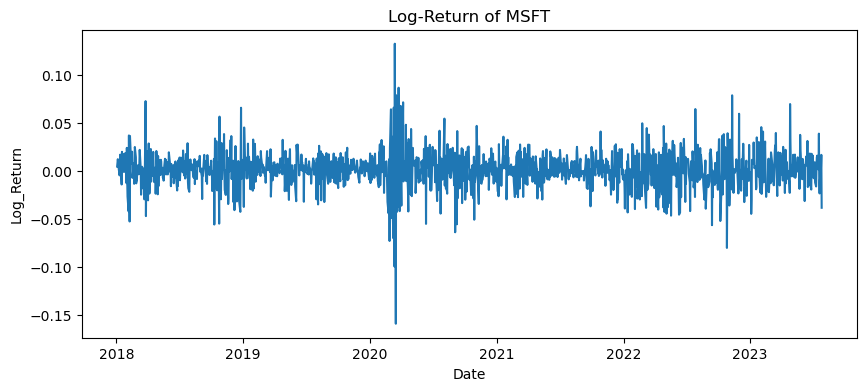

In [11]:
log_return = msft_data['Log_Return']
plt.figure(figsize=(10,4))
plt.plot(log_return)
plt.xlabel('Date')
plt.ylabel('Log_Return')
plt.title('Log-Return of MSFT')
plt.show()

### ARIMA Fit of MSFT Log_Returns

final ARIMA order chosen: (6, 0, 5)


<Figure size 1000x400 with 0 Axes>

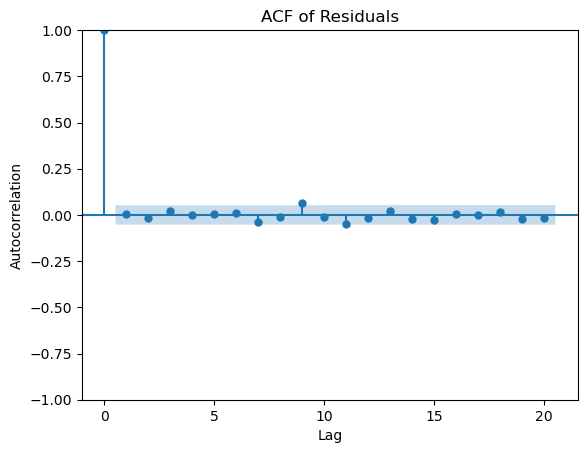

<Figure size 1000x400 with 0 Axes>

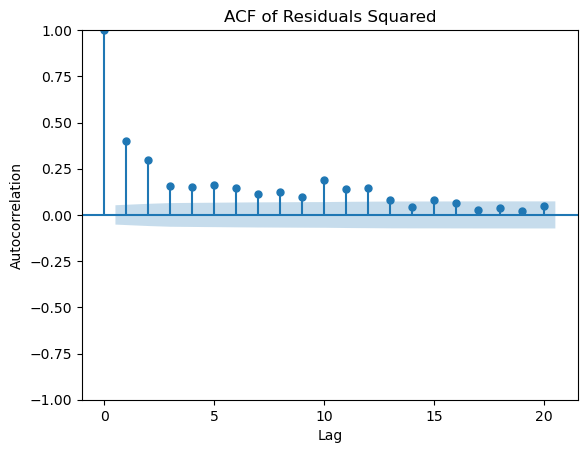

In [4]:
warnings.filterwarnings("ignore")
final_aic = float('inf')
final_order = (0,0,0)
for p in range(7):
    for d in range(3):
        for q in range(7):
            if p==0 and q==0:
                continue
            try:
                # Fit ARIMA model
                model_fit = ARIMA(log_return, order=(p,d,q)).fit()
            except:
                continue

            current_aic = model_fit.aic
            if current_aic<final_aic:
                final_aic = current_aic
                final_order = (p,d,q)
                final_arima = model_fit

print(f'final ARIMA order chosen: {final_order}')
residuals = final_arima.resid
plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=20, alpha=0.05)
plt.title(f'ACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

residual2 = np.square(residuals)
plt.figure(figsize=(10, 4))
plot_acf(residual2, lags=20, alpha=0.05)
plt.title(f'ACF of Residuals Squared')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()             

#### LJUNG-BOX Test To check if the residuals are white noise or not

In [5]:
box_test_result  = acorr_ljungbox(residuals,lags=20,return_df=True)
print(box_test_result[-3:])
if box_test_result.iloc[-1]['lb_pvalue']>0.05:
    print('Residuals are white noise with 95% confidence')

      lb_stat  lb_pvalue
18  15.903901   0.599254
19  16.589675   0.617645
20  16.916177   0.658410
Residuals are white noise with 95% confidence


In [6]:
box_test_result

,lb_stat,lb_pvalue
1,0.020990,0.884806
2,0.439079,0.802888
3,1.068473,0.784690
4,1.068495,0.899238
5,1.094367,0.954601
6,1.233215,0.975212
7,3.415874,0.844054
8,3.641660,0.887922
9,9.289885,0.410957
10,9.520338,0.483533


#### ARIMA Prediction(In-Sample) on different time horizons

In [ ]:
start = '2019-02-01'
end = '2019-07-30'
arima_prediction = final_arima.predict(start=start,end=end)
print(arima_prediction)

Date
2019-02-01    0.007727
2019-02-04    0.001004
2019-02-05    0.001658
2019-02-06   -0.003602
2019-02-07    0.000147
                ...   
2019-07-24    0.001135
2019-07-25   -0.002109
2019-07-26    0.001788
2019-07-29   -0.000901
2019-07-30    0.000346
Name: predicted_mean, Length: 124, dtype: float64


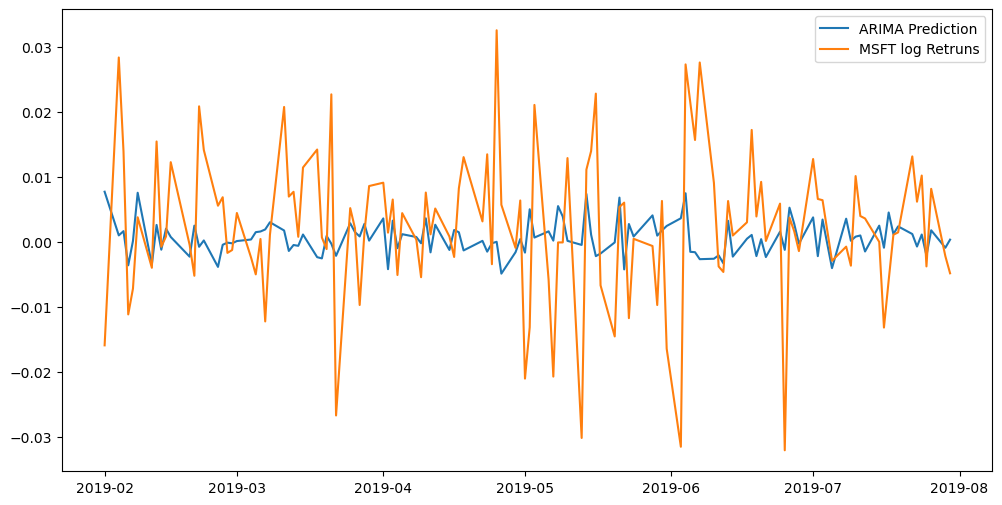

In [9]:
data = log_return.loc['2019-02-01':'2019-07-30']
plt.figure(figsize=(12,6))
plt.plot(arima_prediction,label='ARIMA Prediction')
plt.plot(data,label='MSFT log Retruns')
plt.legend()
plt.show()

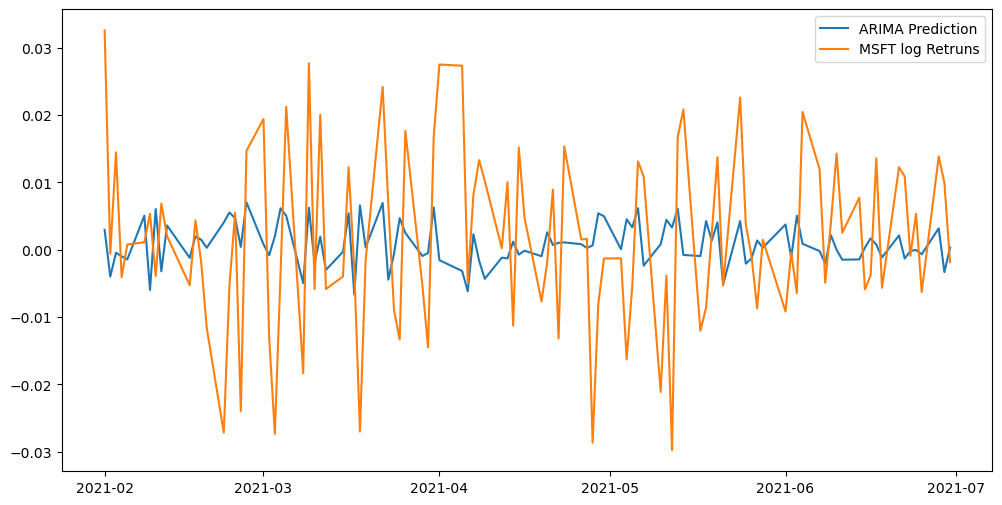

In [10]:
start = '2021-02-01'
end = '2021-06-30'
arima_prediction_2021 = final_arima.predict(start=start,end=end)
data_2021 = log_return.loc[start:end]
plt.figure(figsize=(12,6))
plt.plot(arima_prediction_2021,label='ARIMA Prediction')
plt.plot(data_2021,label='MSFT log Retruns')
plt.legend()
plt.show()

### GARCH Fitting on Residuals of ARIMA fit 
It will allow to capture volatility clustering

#### GARCH with 'Constant' Mean model

In [12]:
vol_forecast = []
residual_forecast = []
test = 252
for i in range(test):
    train = residuals.iloc[i:-test+i]
    #AIC based model selection
    vol_aic = float('inf')
    vol_order = (0,0)
    for p_garch in range(5):
        for q_garch in range(5):
            if p==0 and q==0:
                continue
            try:
                vol_model = arch_model(train,mean='Constant',vol='GARCH',p=p_garch,q=q_garch).fit(disp='off',show_warning=False)
            except:
                continue    
            if vol_model.aic<vol_aic:
                vol_aic = vol_model.aic
                final_vol_model = vol_model
                vol_order = (p_garch,q_garch)
    f = final_vol_model.forecast(horizon=1)
    vol_forecast.append(np.sqrt(f.variance['h.1'].iloc[-1]))
    residual_forecast.append(vol_forecast[i]*np.random.standard_normal()+f.mean['h.1'].iloc[-1])  

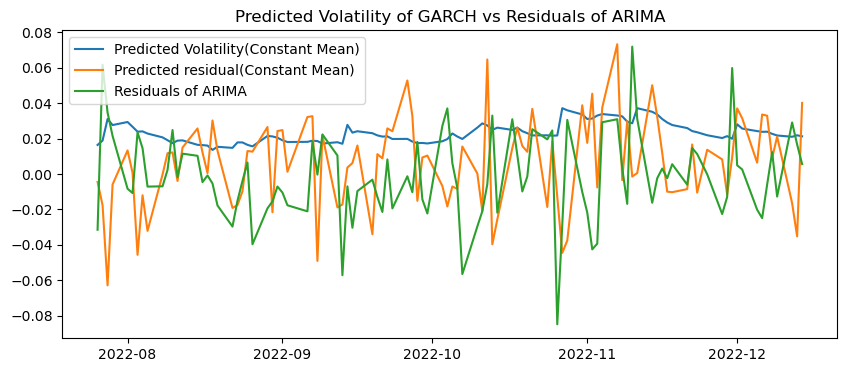

In [13]:
vol_forecast_series = pd.Series(vol_forecast,index=residuals.index[-test:])
residual_forecast_series = pd.Series(residual_forecast,index= residuals.index[-test:])
plt.figure(figsize=(10,4))
plt.plot(vol_forecast_series[:100],label='Predicted Volatility(Constant Mean)')
plt.plot(residual_forecast_series[:100],label='Predicted residual(Constant Mean)')
plt.plot(residuals.iloc[-test:-test+100],label='Residuals of ARIMA')
plt.legend()
plt.title('Predicted Volatility of GARCH vs Residuals of ARIMA')
plt.show()

RMSE of GARCH with 'Constant' mean model is 0.03126543803226173


<Figure size 1000x400 with 0 Axes>

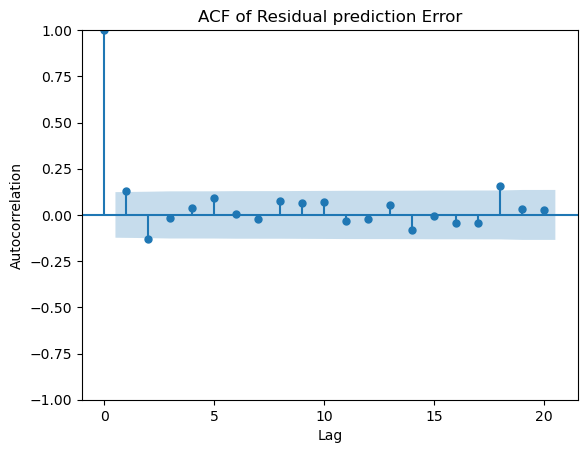

<Figure size 1000x400 with 0 Axes>

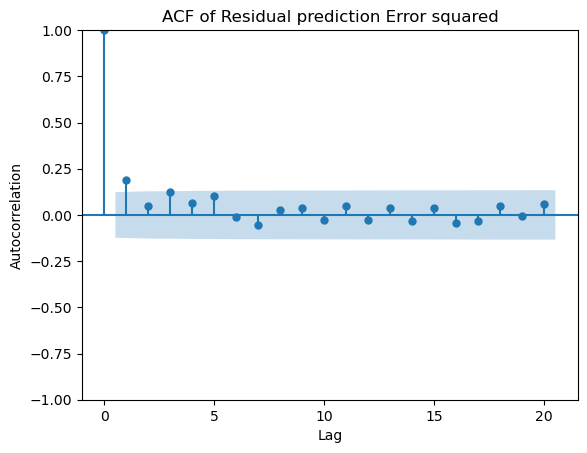

In [14]:
residual_prediction_error = residual_forecast_series - residuals.iloc[-test:]
rmse = np.sqrt(np.square(residual_prediction_error).mean())
print(f"RMSE of GARCH with 'Constant' mean model is {rmse}")
plt.figure(figsize=(10, 4))
plot_acf(residual_prediction_error, lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(np.square(residual_prediction_error), lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error squared')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Observation: Most of variance has been dealt with as evidenced by ACF of Residuals squared

#### GARCH with Zero Mean Model
Motivation: White Noise should have a zero mean

In [15]:
vol_forecast = []
residual_forecast = []
test = 252
for i in range(test):
    train = residuals.iloc[i:-test+i]
    #AIC based model selection
    vol_aic = float('inf')
    vol_order = (0,0)
    for p_garch in range(5):
        for q_garch in range(5):
            if p==0 and q==0:
                continue
            try:
                vol_model = arch_model(train,mean='Zero',vol='GARCH',p=p_garch,q=q_garch).fit(disp='off',show_warning=False)
            except:
                continue    
            if vol_model.aic<vol_aic:
                vol_aic = vol_model.aic
                final_vol_model = vol_model
                vol_order = (p_garch,q_garch)
    f = final_vol_model.forecast(horizon=1)
    vol_forecast.append(np.sqrt(f.variance['h.1'].iloc[-1]))
    residual_forecast.append(vol_forecast[i]*np.random.standard_normal())       

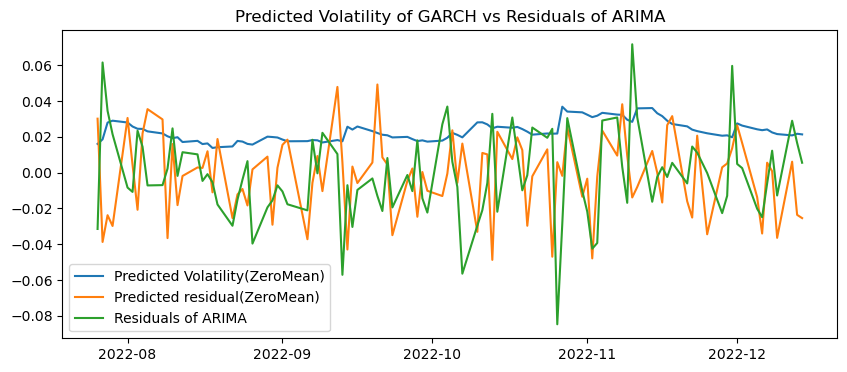

In [16]:
vol_forecast_series = pd.Series(vol_forecast,index=residuals.index[-test:])
residual_forecast_series = pd.Series(residual_forecast,index= residuals.index[-test:])
plt.figure(figsize=(10,4))
plt.plot(vol_forecast_series[:100],label='Predicted Volatility(ZeroMean)')
plt.plot(residual_forecast_series[:100],label='Predicted residual(ZeroMean)')
plt.plot(residuals.iloc[-test:-test+100],label='Residuals of ARIMA')
plt.legend()
plt.title('Predicted Volatility of GARCH vs Residuals of ARIMA')
plt.show()

RMSE of GARCH with 'Zero' mean model is 0.030160805691842433


<Figure size 1000x400 with 0 Axes>

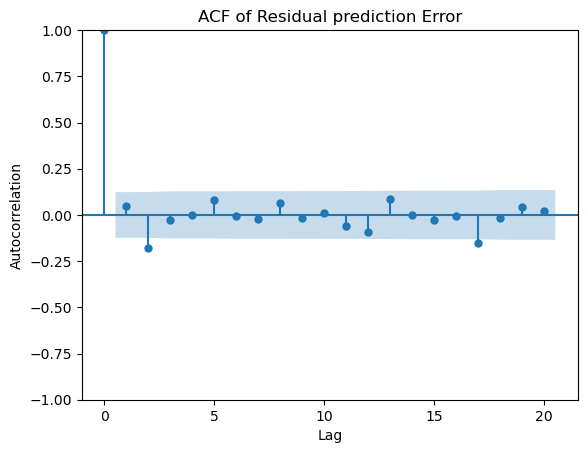

<Figure size 1000x400 with 0 Axes>

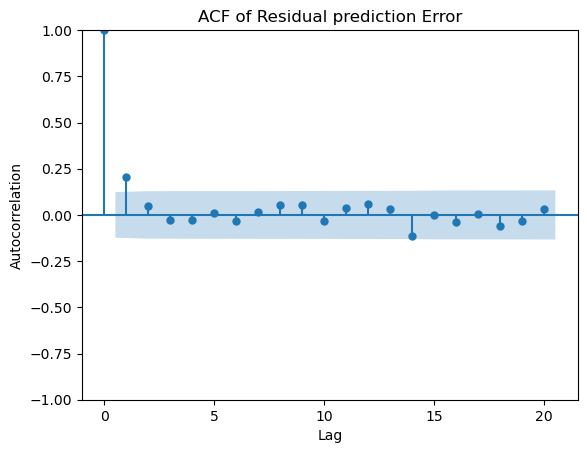

In [17]:
residual_prediction_error = residual_forecast_series - residuals.iloc[-test:]
rmse = np.sqrt(np.square(residual_prediction_error).mean())
print(f"RMSE of GARCH with 'Zero' mean model is {rmse}")
plt.figure(figsize=(10, 4))
plot_acf(residual_prediction_error, lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(np.square(residual_prediction_error), lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [20]:
box_test_result  = acorr_ljungbox(residual_prediction_error,lags=20,return_df=True)
print(box_test_result[-3:])
if box_test_result.iloc[-1]['lb_pvalue']>0.05:
    print('Residual prediction errors are white noise with 95% confidence')

      lb_stat  lb_pvalue
18  24.404489   0.142218
19  24.920079   0.163190
20  25.039236   0.199934
Residual prediction errors are white noise with 95% confidence


So, we see that serial correlations of variance of residuals of ARIMA has been dealt with at a good percent. So we can hope for a better fit now with ARIMA+GARCH on MSFT log-returns

### ARIMA+GARCH Rolling Out-of-sample prediction of returns

In [21]:
warnings.filterwarnings("ignore")
predicton = []
fail = {}
test = 30
for i in range(test):
    train = log_return.iloc[i:-test+i]
    #AIC Based ARIMA model selection
    final_aic = float('inf')
    for p in range(6):
        for d in range(3):
            for q in range(6):
                if p==0 and q==0:
                    continue
                try:
                    # Fit ARIMA model
                    model_fit = ARIMA(train, order=(p,d,q)).fit()
                except:
                    continue

                current_aic = model_fit.aic
                if current_aic<final_aic:
                    final_aic = current_aic
                    final_arima = model_fit
    residuals = final_arima.resid
    box_test_result  = acorr_ljungbox(residuals,lags=20,return_df=True)
    if box_test_result.iloc[-1]['lb_pvalue']>0.05:
        #AIC based GARCH Model Selection and fitting:
        vol_aic = float('inf')
        for p_garch in range(5):
            for q_garch in range(5):
                if p==0 and q==0:
                    continue
                try:
                    vol_model = arch_model(residuals,mean='Zero',vol='GARCH',p=p_garch,q=q_garch).fit(disp='off',show_warning=False)
                except:
                    continue    
                if vol_model.aic<vol_aic:
                    vol_aic = vol_model.aic
                    final_vol_model = vol_model
        #Prediction with arima+garch
        predicted_mu = final_arima.forecast(steps=1).iloc[0]
        garch_forecast = final_vol_model.forecast(horizon=1)
        predicted_et = np.sqrt(garch_forecast.variance['h.1'].iloc[-1])*np.random.standard_normal()
        final_prediction = predicted_mu+predicted_et
        predicton.append(final_prediction)
    else:
        print(f'could not fit ARIMA on {log_return.index[i+test]}')
        fail[log_return.index[i-test]] = 1



In [30]:
#For ARIMA prediction only
start = '2023-06-13'
end = '2023-07-25'
arima_prediction = final_arima.predict(start=start,end=end)

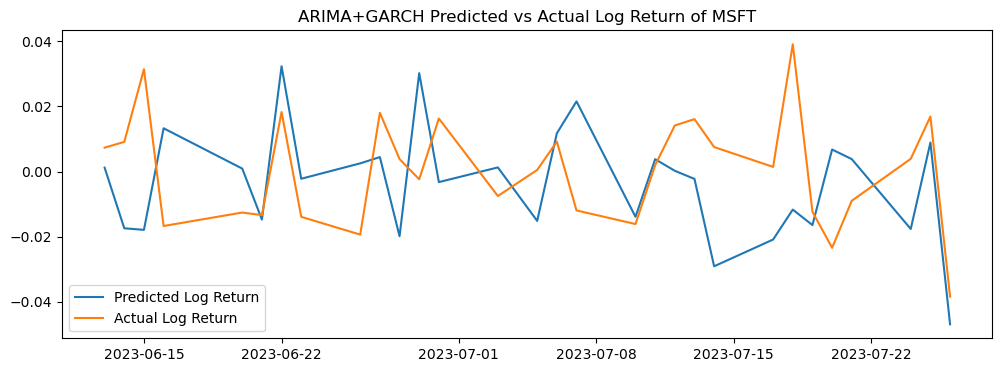

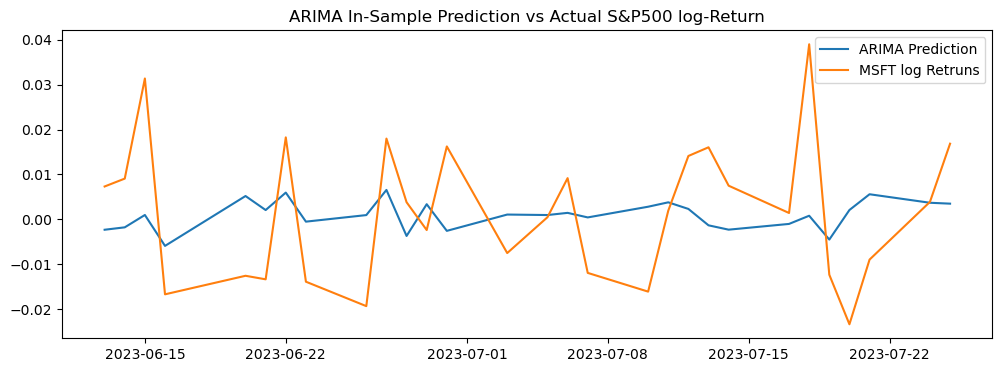

In [28]:
forecast_series = pd.Series(predicton,index= log_return.index[-test:])
plt.figure(figsize=(12,4))
plt.plot(forecast_series,label='Predicted Log Return')
plt.plot(log_return.iloc[-test:],label='Actual Log Return')
plt.legend()
plt.title('ARIMA+GARCH Predicted vs Actual Log Return of MSFT')
plt.show()

data = log_return.loc[start:end]
plt.figure(figsize=(12,4))
plt.plot(arima_prediction,label='ARIMA Prediction')
plt.plot(data,label= 'MSFT log Retruns')
plt.title("ARIMA In-Sample Prediction vs Actual S&P500 log-Return")
plt.legend()
plt.show()

In [31]:
prediction_error = forecast_series - log_return.iloc[-test:]
rmse = np.sqrt((np.square(prediction_error)).mean())
print(f'RMSE of the ARIMA+GARCH model: {rmse}')

RMSE of the ARIMA+GARCH model: 0.0226004116589615
